In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [2]:
import pickle
import json

In [3]:
from nltk import ngrams

In [4]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [5]:
class Population:
    '''
    Class representing CRISPR cassettes population + PCR model
    '''
    
    def __init__(self,
                 population_f,
                 population_b, 
                 default_switch = 0, 
                 default_amplify = 1):
        self.population_f = population_f
        self.population_b = population_b
        self.default_switch = default_switch
        self.default_amplify = default_amplify
        
        
        
    def check(pf, pb, **kw):
        return Population(pf, pb, kw)
    
    def from_list_of_lists(list_of_lists, cassettes_types = None, multiplier = 1):
        max_len = max([len(x) for x in list_of_lists])
        
        population_f = np.ones((len(list_of_lists), max_len + 1)) * (-1)
        population_b = np.ones((len(list_of_lists), max_len + 1)) * (-1)
        
        for i, l in enumerate(list_of_lists):
            population_f[i, 1:len(l) + 1] = np.array(l)
            population_b[i, 1:len(l) + 1] = np.array(l[::-1])

        if cassettes_types is not None:
            population_f[:,0],population_b[:,0] = [np.array(cassettes_types)]*2
        else:
            population_f[:,0],population_b[:,0] = [0]*2

        if multiplier > 1:
            population_f = np.vstack([population_f] * multiplier)
            population_b = np.vstack([population_b] * multiplier)
        
        return Population(population_f, population_b, 1)
        

    

In [6]:
p = Population(2,3,asasa = 12)

TypeError: __init__() got an unexpected keyword argument 'asasa'

In [7]:
Population.check(1,2,switch=0)

In [8]:
population_as_list = [[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(5)] + \
               [[4, 2, 5, 7, 11] for i in range(5)] + \
               [[24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34]] + \
               [[20, 22, 23, 21, 29]]

pairs_1 = set([x for y in population_as_list[:10] for x in ngrams(y, 2)])
pairs_2 = set([x for y in population_as_list[10:] for x in ngrams(y, 2)])

In [9]:
SWITCH_PROB = 0.2
AMPLIFY_PROB = 1.
STOP_PROB = 0
MAX_LEN = 5

In [10]:
MAX_LEN = 6
population = np.ones((3,MAX_LEN + 1)) * -1
population[0,0:6] = np.arange(0,6)
population[0,0] = 0
population[1,0:6] = np.arange(6,12)
population[1,0] = 1
population[2,0:6] = np.arange(12,18)
population[2,0] = 2
population

array([[  0.,   1.,   2.,   3.,   4.,   5.,  -1.],
       [  1.,   7.,   8.,   9.,  10.,  11.,  -1.],
       [  2.,  13.,  14.,  15.,  16.,  17.,  -1.]])

In [11]:
population_f = population.copy()
population_b = reverse_population(population_f)

NameError: name 'reverse_population' is not defined

In [12]:
single_amplify(population_f, np.ones(3), 1,1)

NameError: name 'single_amplify' is not defined

In [13]:
population_f

array([[  0.,   1.,   2.,   3.,   4.,   5.,  -1.],
       [  1.,   7.,   8.,   9.,  10.,  11.,  -1.],
       [  2.,  13.,  14.,  15.,  16.,  17.,  -1.]])

In [14]:
population_b

NameError: name 'population_b' is not defined

In [15]:
population_f, population_b = PCR_cycle(population_f, population_b, np.array([1,1,1]))

NameError: name 'PCR_cycle' is not defined

In [16]:
def reverse_population(p):
    p_b = p.copy()
    for i in range(p.shape[0]):
        length = (p[i] != -1).sum() - 1
        
        p_b[i,1:length + 1] = p[i,1:length + 1][::-1]
    return p_b

In [17]:
def PCR_cycle(population_f, population_b, switch_weights):       
    new_f = single_amplify(population_f, switch_weights, reverse=0)
    #new_b = single_amplify(population_f, switch_weights)
    
    population_f = np.vstack((population_f, new_f))
    #population_b = np.vstack((population_b, new_b))
    
    return population_f, population_b

In [18]:
def generate_initial_population(spacers_num, chain_number=2, max_amount_per_chain = 2, min_len = 4, v = False):
    # markov is our god! 
    graph = np.zeros((spacers_num, spacers_num))
    for i in range(spacers_num):
        for j in range(spacers_num -1, i, -1):
            graph[i,j] = spacers_num - j

    if v:
        plot_gr(graph)
        
    graph /= np.max(np.vstack((graph.sum(1), np.ones(spacers_num))), 0).reshape(-1,1)
    all_chains = []
    while len(all_chains) < chain_number:
        chain = []
        amount = np.random.randint(1, max_amount_per_chain)
        max_len = max([np.random.randint(min_len,spacers_num + 1) for i in range(3)])
        curr = np.random.randint(0, (spacers_num - 1) / 2 )

        for j in range(max_len):
            chain.append(curr)
            if curr != spacers_num - 1:
                #print(np.arange(spacers_num), graph[curr])
                curr = np.random.choice(np.arange(spacers_num), 1, p = graph[curr])[0]
            else:
                break
        
        if len(chain) > min_len:
            all_chains.extend([chain for k in range(amount)])
    
    return all_chains[:chain_number]

In [19]:
def population_from_list_of_lists(list_of_lists, cassettes_types = None, multiplier = 1):
    max_len = max([len(x) for x in list_of_lists])
    population_f = np.ones((len(list_of_lists), max_len + 1)) * (-1)
    population_b = np.ones((len(list_of_lists), max_len + 1)) * (-1)
    for i,l in enumerate(list_of_lists):
        population_f[i, 1:len(l) + 1] = np.array(l)
        population_b[i, 1:len(l) + 1] = np.array(l[::-1])
        
    if cassettes_types is not None:
        population_f[:,0],population_b[:,0] = [np.array(cassettes_types)]*2
        
    else:
        population_f[:,0],population_b[:,0] = [0]*2
    
    if multiplier > 1:
        population_f = np.vstack([population_f] * multiplier)
        population_b = np.vstack([population_b] * multiplier)
    return population_f, population_b, max_len
        

In [20]:
population_as_list = [[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(5)] + \
               [[4, 2, 5, 7, 11] for i in range(5)] + \
               [[24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34]] + \
               [[20, 22, 23, 21, 29]]

pairs_1 = set([x for y in population_as_list[:10] for x in ngrams(y, 2)])
pairs_2 = set([x for y in population_as_list[10:] for x in ngrams(y, 2)])

In [21]:
all_ratios_plots = []

In [22]:
np.random.randint(1,3,10)

array([1, 1, 2, 1, 1, 2, 2, 2, 1, 2])

In [23]:
def single_amplify(all_population, switch_weights, reverse = True, v = False): 
    mask = np.random.binomial(1, AMPLIFY_PROB, all_population.shape[0]).astype(bool)
    population_to_amplify = all_population[mask] 
    new = np.ones((population_to_amplify.shape[0], MAX_LEN + 1)) * (-1)
    
    if v:
        print(mask)
        print(population_to_amplify)
    
    i = 0
    for chain in population_to_amplify:
        source_len = (chain != -1).sum() - 1 
        to_start = False
        start = 0
        while not to_start and start < source_len:
            start += 1
            if np.random.random() < START_PROB:
                to_start = True
        if v: print("start : ", start)
            
        #start = np.random.randint(1, source_len + 1 - 1)
        stop = False
#        end = np.random.randint(start + 1, source_len + 1)
        
        
        pointer_new = 1
        pointer_source = start
        
        new[i,0] = chain[0]
        
        while not stop:            
            new[i,pointer_new] = chain[pointer_source]
            
            pointer_new += 1
            pointer_source += 1
            
            switch = np.random.rand() < SWITCH_PROB
            
            if v:
                print(chain, new[i], switch)
            if switch:
                mask = np.zeros(1)
                while mask.sum() ==0:
                    chain_type = np.random.choice(np.arange(switch_weights.shape[0]), p = switch_weights / switch_weights.sum())
                    mask = population_to_amplify[:, 0] == chain_type

                chain = population_to_amplify[mask][np.random.randint(0, mask.sum())]
                source_len = (chain != -1).sum() - 1 
                pointer_source = np.random.randint(1, source_len)

            if np.random.rand() < STOP_PROB:
                stop = True
            if pointer_new == new.shape[1]:
                stop = True
#             if pointer_new == end:
#                 stop = True
            if pointer_source == source_len + 1:
                if np.random.rand() < SWITCH_PROB :
                    mask = np.zeros(1)
                    while mask.sum() ==0:
                        chain_type = np.random.choice(np.arange(switch_weights.shape[0]), p = switch_weights / switch_weights.sum())
                        mask = population_to_amplify[:, 0] == chain_type

                    chain = population_to_amplify[mask][np.random.randint(0, mask.sum())]
                    source_len = (chain != -1).sum() - 1 
                    pointer_source = np.random.randint(1, source_len)
                else:
                    stop = True
            
#                 if v:
#                     print(chain, new[i], switch)

#                 mask = np.zeros(1)
#                 while mask.sum() ==0:
#                     chain_type = np.random.choice(np.arange(switch_weights.shape[0]), p = switch_weights / switch_weights.sum())
#                     mask = population_to_amplify[:, 0] == chain_type

#                 chain = population_to_amplify[mask][np.random.randint(0, mask.sum())]
#                 source_len = (chain != -1).sum() - 1 
#                 pointer_source = np.random.randint(1, source_len)
 
                
                
                
                
        if reverse:
            if v:print(new[i], pointer_new)
            new[i, 1:pointer_new] = new[i, pointer_new - 1:0:-1]
            if v:print(new[i])
        if (new[i] != -1).sum() > 2:
            i += 1
        
    
    return new[(new != -1).sum(1) > 2 ]
    
     

In [24]:
SWITCH_PROB = 0.03
AMPLIFY_PROB = 0.3
STOP_PROB = 0.05
START_PROB = 0.85

In [25]:
population_f, population_b, MAX_LEN = population_from_list_of_lists(population_as_list, [0]*10 + [1]*2, 10)

A Jupyter Widget

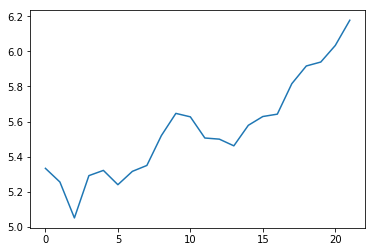

In [26]:
population_ratio = []

for i in tqdm_notebook(range(50)) :
    all_pairs = []
    for seq in np.vstack((population_f,reverse_population(population_b))):
        seq = seq[seq != -1][1:]
        for x in ngrams(seq,2):
            all_pairs.append(x)
            
    cp_1, cp_2, cp_3 = 0,0,0
    for p in all_pairs:
        if p in pairs_1:
            cp_1+=1
        elif p in pairs_2:
            cp_2+=1
        else:
            cp_3+=1

    population_ratio.append(cp_1 / cp_2)
    
    population_f, population_b = PCR_cycle(population_f, population_b, np.array([50,1]))

    if population_f.shape[0] > 20000:
        break

all_ratios_plots.append(population_ratio)

for p_r in all_ratios_plots:
    plt.plot(p_r)
plt.show()